# 불러오기들

In [488]:
import numpy
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import pandas

from konlpy.tag import Mecab, Kkma
import konlpy.jvm as konlpyJvm

from collections import Counter

import math
import matplotlib.pyplot as pyplot
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import Word2Vec
from tensorflow.keras.initializers import Constant

# 데이터 가공 함수

In [489]:
g_mecab = Mecab()
g_kkma = Kkma()

def split_sentence(sentence):
    return [word for word, _ in g_mecab.pos(sentence)]
    # return [word for word, _ in g_kkma.pos(sentence)]

def encode_sentence(sentence, word_to_index):
    '''
    sentence      : 인코딩 할 문장
    word_to_index : 인코딩 기반 코드, {str:int}
    
    return        : 인코딩 된 문장, 예) [1, x, x, x...]
    '''
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in split_sentence(sentence)]

def encode_sentences(sentences, word_to_index):
    '''
    sentences     : 인코딩 할 문장 리스트
    word_to_index : 인코딩 기반 코드, {str:int}
    
    return        : 인코딩 된 문장 리스트, 예) [[1, x, x, x...], [1, ...], ...]
    '''
    return [encode_sentence(sentence, word_to_index) for sentence in sentences]

def decode_sentence(encoded, index_to_word):
    '''
    encoded       : 디코딩 할 리스트, [int]
    index_to_word : 디코딩 기반 코드, {int:str}
    
    return        : 디코딩 된 문장
    '''
    return ''.join([index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded[1:]])

def decode_sentences(encodeds, index_to_word):
    '''
    encodeds      : 디코딩 할 리스트, [int]
    index_to_word : 디코딩 기반 코드, {int:str}
    
    return        : 디코딩 된 문장 리스트
    '''
    return [decode_sentence(encoded, index_to_word) for encoded in encodeds]

In [490]:
def get_word_to_index(sentences, num_words):
    '''
    sentences : 처리할 문장 리스트
    num_words : 사용할 단어 수, 가장 자주 사용되는 순으로 센다
    
    return    : {단어:정수}, <PAD>, <BOS>, <UNK>, <UNUSED>는 각각 1,2,3,4로 정해져 있다
    '''
    # stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    stop_words = []
    words = []
    for sentence in sentences:
        words.extend([word for word in split_sentence(sentence) if word not in stop_words])
    most_common_words = [word for word, _ in Counter(words).most_common(num_words)]
    print('가장 많이 사용되는 단어 Top 20: ', most_common_words[:20])
    
    word_to_index = {
        '<PAD>': 0,
        '<BOS>': 1,
        '<UNK>': 2,
        '<UNUSED>': 3
    }
    for index, word in enumerate(most_common_words, start=4):
        word_to_index[word] = index
    print('가장 많이 사용하는 단어 ', len(word_to_index), '개를 추출하였습니다')
    
    return word_to_index    

In [491]:
def load_data(raw_train_data, raw_test_data, num_words=None):
    '''
    raw_train_data : 훈련에 사용될 데이터 원본, DataFrame
    raw_test_data  : 테스트에 사용될 데이터 원본, DataFrame
    num_words      : 사용할 단어 수, 가장 자주 사용되는 순으로 센다
    '''
    print('데이터 불러오기 시작')
    train_data = raw_train_data.drop_duplicates(subset='document').dropna()
    test_data = raw_test_data.drop_duplicates(subset='document').dropna()
    
    train_sentences = train_data['document']
    test_sentences = test_data['document']
    print('파일 열기 성공')
    
    print('인덱스 생성 시작')
    word_to_index = get_word_to_index(train_sentences, num_words=num_words)
    print('인덱스 생성 성공')
    
    print('문장 데이터 인코딩 시작')
    encoded_train_sentences = encode_sentences(train_sentences, word_to_index)
    encoded_test_sentences = encode_sentences(test_sentences, word_to_index)
    print('문장 데이터 인코딩 성공')
    
    return encoded_train_sentences, train_data['label'], encoded_test_sentences, test_data['label'], word_to_index
    

# 처리할 문장 길이를 찾는 함수

In [492]:
def find_max_len(encoded_sentences):
    '''
    sentences : 처리할 문장 리스트, 문자열 리스트가 아닌 인코딩 된 [int]
    
    return    : 적절한 문장 길이
    '''
    lengths = numpy.array([len(sentence) for sentence in encoded_sentences])
    print('단어 수 평균 : ', numpy.mean(lengths))
    print('단어 수 최대 : ', numpy.max(lengths))
    print('단어 수 표준편차 : ', numpy.std(lengths))
    return int(numpy.mean(lengths) + 2 * numpy.std(lengths))

# 임베딩 모델생성 함수

In [493]:
def get_normal_embedding_model(vocab_size):
    '''
    임베딩 초기화가 없는 경우 모델
    '''
    print('임베딩 초가화가 없는 모델입니다')
    word_dim = int(math.log2(vocab_size)) + 1
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_dim, input_shape=(None,)))
    return model

def get_initialized_embedding_model(vocab_size, embeddings_initializer, input_length):
    '''
    임베딩 초기화가 있는 경우 모델
    '''
    print('임베딩 초가화가 있는 모델입니다')
    word_dim = embeddings_initializer.shape[1]

    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, 
                                 word_dim, 
                                 embeddings_initializer=Constant(embeddings_initializer),
                                 input_length=input_length, 
                                 trainable=True))
    return model

# LSTM 모델 생성 함수

In [494]:
def make_model_1(input_length, word_to_index, embeddings_initializer='uniform'):
    vocab_size = len(word_to_index)
    if isinstance(embeddings_initializer, str):
        model = get_normal_embedding_model(vocab_size)
    else:
        model = get_initialized_embedding_model(vocab_size, embeddings_initializer, input_length)

    model.add(keras.layers.LSTM(16))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(4, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Conv1D 모델 생성 함수

In [495]:
def make_model_2(input_length, word_to_index, embeddings_initializer='uniform'):
    vocab_size = len(word_to_index)
    if isinstance(embeddings_initializer, str):
        model = get_normal_embedding_model(vocab_size)
    else:
        model = get_initialized_embedding_model(vocab_size, embeddings_initializer, input_length)

    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.MaxPooling1D(5))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.summary()
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# GlobalMaxPooling1D 모델 생성 함수

In [496]:
def make_model_3(input_length, word_to_index, embeddings_initializer='uniform'):
    vocab_size = len(word_to_index)
    if isinstance(embeddings_initializer, str):
        model = get_normal_embedding_model(vocab_size)
    else:
        model = get_initialized_embedding_model(vocab_size, embeddings_initializer, input_length)

    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.summary()
    
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    

# 학습, 테스트 결과 보여주는 함수

In [497]:
def show_result(evaludate_result, history):
    print('테스트 결과: ', evaluate_result)
    loss = history['loss']
    accuracy = history['accuracy']
    val_loss = history['val_loss']
    val_accuracy = history['val_accuracy']

    epochs = range(1, len(accuracy) + 1)

    pyplot.plot(epochs, loss, 'bo', label='Training loss')
    pyplot.plot(epochs, val_loss, 'b', label='Validation loss')
    pyplot.title('Training and validation loss')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.show()
    
    pyplot.clf()
    pyplot.plot(epochs, accuracy, 'bo', label='Training acc')
    pyplot.plot(epochs, val_accuracy, 'b', label='Validation acc')
    pyplot.title('Training and validation accuracy')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Accuracy')
    pyplot.legend()
    pyplot.show()

In [498]:
def show_embedding_layer(layer, word_to_index, example):
    weights = layer.get_weights()[0]
    vocab_size = weights.shape[0]
    word_vector_dim =  weights.shape[1]
    print('생성된 임베딩 레이어 shape: ', weights.shape)  
    index_to_word = {index:word for index, word in enumerate(word_to_index)}
    
    word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(weights[i, :])))))
    f.close()

    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    print(example, '와(과) 비슷한 항목들: ', word_vectors.similar_by_word(example))

# 임베딩된 행렬 불러오기 함수

In [499]:
def load_embeddings_initializer(word_to_index):
    word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
    word2vec = Word2Vec.load(word2vec_path)
    
    count = 0
    embedding_matrix = numpy.random.rand(len(word_to_index), word2vec.vector_size)
    for word, index in word_to_index.items():
        if word in word2vec.wv:
            count = count + 1
            embedding_matrix[index] = word2vec.wv[word]
    print(count, '개 단어가 사전 임베딩에 추가 되었습니다')
    return embedding_matrix



# 메인

데이터 준비

In [500]:
train_data = pandas.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pandas.read_table('~/aiffel/sentiment_classification/ratings_test.txt')
# train_data
# test_data

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data, num_words=10000)

max_len = find_max_len(x_train+x_test)
print(max_len)


# LSTM은 패딩을 pre로 설정
x_train_lstm = keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=max_len)
x_test_lstm = keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=max_len)

# 다른 모델은 패딩을 post로 설정
x_train = keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index['<PAD>'], padding='post', maxlen=max_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index['<PAD>'], padding='post', maxlen=max_len)

# 하이퍼파라미터 설정
epochs=100
num_val=30000


데이터 불러오기 시작
파일 열기 성공
인덱스 생성 시작
가장 많이 사용되는 단어 Top 20:  ['.', '이', '는', '영화', '다', '고', '하', '도', '의', '가', '은', '에', '을', '보', '한', '..', '게', ',', '들', '!']
가장 많이 사용하는 단어  10004 개를 추출하였습니다
인덱스 생성 성공
문장 데이터 인코딩 시작
문장 데이터 인코딩 성공
단어 수 평균 :  19.722963668289488
단어 수 최대 :  117
단어 수 표준편차 :  15.329504488772837
50


## LSTM 모델

모델 생성

In [501]:
model = make_model_1(x_train_lstm.shape[1], word_to_index)

임베딩 초가화가 없는 모델입니다
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_65 (Embedding)     (None, None, 14)          140056    
_________________________________________________________________
lstm_23 (LSTM)               (None, 16)                1984      
_________________________________________________________________
dense_140 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_141 (Dense)            (None, 4)                 68        
_________________________________________________________________
dense_142 (Dense)            (None, 1)                 5         
Total params: 142,385
Trainable params: 142,385
Non-trainable params: 0
_________________________________________________________________


훈련 및 테스트

In [502]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(x_train_lstm[:-num_val],
                    y_train[:-num_val],
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_train_lstm[-num_val:], y_train[-num_val:]),
                    verbose=1,
                    callbacks=[early_stopping])
evaluate_result = model.evaluate(x_test_lstm,  y_test, verbose=2)

Epoch 1/100
227/227 [==============================] - 2s 8ms/step - loss: 0.5498 - accuracy: 0.7472 - val_loss: 0.4016 - val_accuracy: 0.8289
Epoch 2/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3634 - accuracy: 0.8454 - val_loss: 0.3610 - val_accuracy: 0.8446
Epoch 3/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3332 - accuracy: 0.8586 - val_loss: 0.3492 - val_accuracy: 0.8499
Epoch 4/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3217 - accuracy: 0.8636 - val_loss: 0.3454 - val_accuracy: 0.8512
Epoch 5/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3142 - accuracy: 0.8677 - val_loss: 0.3437 - val_accuracy: 0.8521
Epoch 6/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3076 - accuracy: 0.8704 - val_loss: 0.3429 - val_accuracy: 0.8514
Epoch 7/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3021 - accuracy: 0.8729 - val_loss: 0.3390 - val_accuracy: 0.8545

결과 보여주기

테스트 결과:  [0.33627960085868835, 0.8581076860427856]


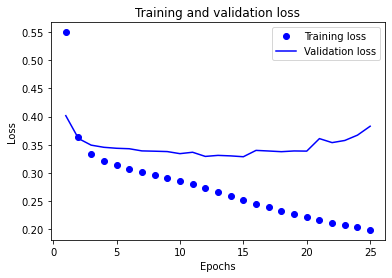

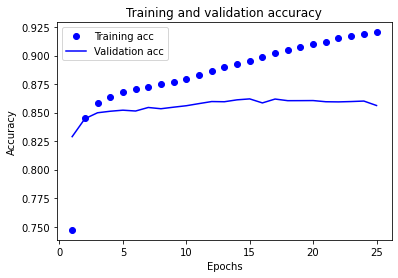

In [503]:
show_result(evaluate_result, history.history)

In [504]:
show_embedding_layer(model.layers[0], word_to_index, '영화')

생성된 임베딩 레이어 shape:  (10004, 14)
영화 와(과) 비슷한 항목들:  [('~~', 0.9579397439956665), ('작렬', 0.9340403079986572), ('호소', 0.9262877106666565), ('꽁', 0.9254338145256042), ('덩어리', 0.9253154397010803), ('안겨', 0.9247336387634277), ('시킨', 0.9227634072303772), ('줘야', 0.9220930337905884), ('마구', 0.9215102195739746), ('싸', 0.9197086691856384)]


## Conv1D 모델

모델 생성

In [505]:
model = make_model_2(x_train.shape[1], word_to_index)

임베딩 초가화가 없는 모델입니다
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (None, None, 14)          140056    
_________________________________________________________________
conv1d_42 (Conv1D)           (None, None, 16)          1584      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_42 (Glo (None, 16)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_144 (Dense)            (None,

훈련 및 테스트

In [506]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(x_train[:-num_val],
                    y_train[:-num_val],
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_train[-num_val:], y_train[-num_val:]),
                    verbose=1,
                    callbacks=[early_stopping])
evaluate_result = model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/100
227/227 [==============================] - 1s 5ms/step - loss: 0.4995 - accuracy: 0.7617 - val_loss: 0.3740 - val_accuracy: 0.8359
Epoch 2/100
227/227 [==============================] - 1s 5ms/step - loss: 0.3476 - accuracy: 0.8509 - val_loss: 0.3541 - val_accuracy: 0.8441
Epoch 3/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3223 - accuracy: 0.8636 - val_loss: 0.3408 - val_accuracy: 0.8536
Epoch 4/100
227/227 [==============================] - 1s 5ms/step - loss: 0.3052 - accuracy: 0.8723 - val_loss: 0.3425 - val_accuracy: 0.8531
Epoch 5/100
227/227 [==============================] - 1s 5ms/step - loss: 0.2915 - accuracy: 0.8788 - val_loss: 0.3340 - val_accuracy: 0.8574
Epoch 6/100
227/227 [==============================] - 1s 5ms/step - loss: 0.2781 - accuracy: 0.8852 - val_loss: 0.3312 - val_accuracy: 0.8595
Epoch 7/100
227/227 [==============================] - 1s 5ms/step - loss: 0.2647 - accuracy: 0.8913 - val_loss: 0.3349 - val_accuracy: 0.8579

결과 보여주기

테스트 결과:  [0.3384745717048645, 0.8561140894889832]


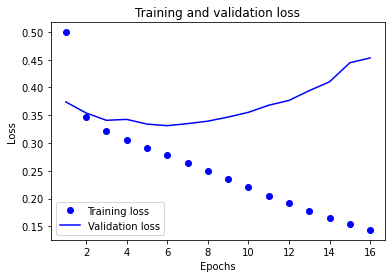

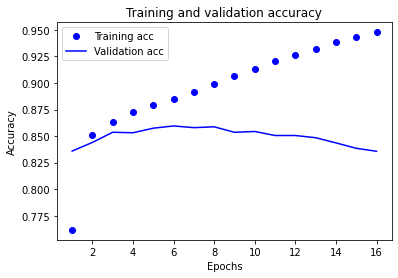

In [507]:
show_result(evaluate_result, history.history)

In [508]:
show_embedding_layer(model.layers[0], word_to_index, '영화')

생성된 임베딩 레이어 shape:  (10004, 14)
영화 와(과) 비슷한 항목들:  [('지상파', 0.809547483921051), ('고현정', 0.7668324112892151), ('직업', 0.7387794256210327), ('닷', 0.724733829498291), ('빨리', 0.7229861617088318), ('페넬로페', 0.6976389288902283), ('끝내', 0.6965119242668152), ('월드', 0.6944001317024231), ('~~!!!', 0.6889480352401733), ('메인', 0.6880849003791809)]


## GlobalMaxPooling1D 모델

모델 생성

In [509]:
model = make_model_3(x_train.shape[1], word_to_index)

임베딩 초가화가 없는 모델입니다
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_67 (Embedding)     (None, None, 14)          140056    
_________________________________________________________________
global_max_pooling1d_43 (Glo (None, 14)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 8)                 120       
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 9         
Total params: 140,185
Trainable params: 140,185
Non-trainable params: 0
_________________________________________________________________


훈련 및 테스트

In [510]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(x_train[:-num_val],
                    y_train[:-num_val],
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_train[-num_val:], y_train[-num_val:]),
                    verbose=1,
                    callbacks=[early_stopping])
evaluate_result = model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/100
227/227 [==============================] - 1s 4ms/step - loss: 0.6274 - accuracy: 0.7276 - val_loss: 0.5377 - val_accuracy: 0.8005
Epoch 2/100
227/227 [==============================] - 1s 4ms/step - loss: 0.4591 - accuracy: 0.8179 - val_loss: 0.4115 - val_accuracy: 0.8243
Epoch 3/100
227/227 [==============================] - 1s 4ms/step - loss: 0.3744 - accuracy: 0.8416 - val_loss: 0.3739 - val_accuracy: 0.8359
Epoch 4/100
227/227 [==============================] - 1s 4ms/step - loss: 0.3434 - accuracy: 0.8534 - val_loss: 0.3613 - val_accuracy: 0.8430
Epoch 5/100
227/227 [==============================] - 1s 4ms/step - loss: 0.3280 - accuracy: 0.8606 - val_loss: 0.3561 - val_accuracy: 0.8464
Epoch 6/100
227/227 [==============================] - 1s 4ms/step - loss: 0.3177 - accuracy: 0.8655 - val_loss: 0.3539 - val_accuracy: 0.8462
Epoch 7/100
227/227 [==============================] - 1s 4ms/step - loss: 0.3101 - accuracy: 0.8687 - val_loss: 0.3526 - val_accuracy: 0.8488

결과 보여주기

테스트 결과:  [0.3608874976634979, 0.8444982171058655]


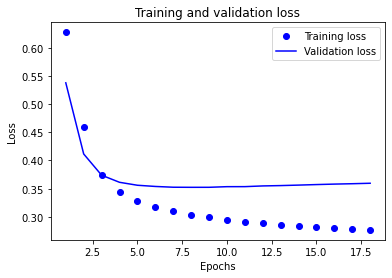

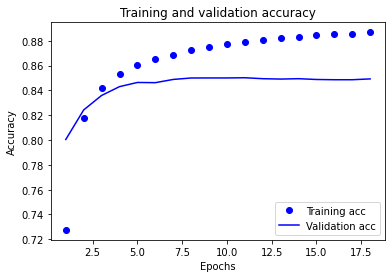

In [511]:
show_result(evaluate_result, history.history)

In [512]:
show_embedding_layer(model.layers[0], word_to_index, '영화')

생성된 임베딩 레이어 shape:  (10004, 14)
영화 와(과) 비슷한 항목들:  [('본', 0.9996275901794434), ('였', 0.9993011951446533), ('아', 0.9980669021606445), ('여', 0.997321605682373), ('에', 0.9972458481788635), ('었', 0.9972337484359741), ('은', 0.9972079992294312), ('음', 0.9971817135810852), ('는데', 0.9966236352920532), ('느낌', 0.9963937997817993)]


## LSTM + pre embedding 모델

모델 생성

In [513]:
embeddings_initializer = load_embeddings_initializer(word_to_index)
model = make_model_1(x_train_lstm.shape[1], word_to_index, embeddings_initializer=embeddings_initializer)

5818 개 단어가 사전 임베딩에 추가 되었습니다
임베딩 초가화가 있는 모델입니다
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_68 (Embedding)     (None, 50, 200)           2000800   
_________________________________________________________________
lstm_24 (LSTM)               (None, 16)                13888     
_________________________________________________________________
dense_147 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_148 (Dense)            (None, 4)                 68        
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 5         
Total params: 2,015,033
Trainable params: 2,015,033
Non-trainable params: 0
_________________________________________________________________


훈련 및 테스트

In [514]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(x_train_lstm[:-num_val],
                    y_train[:-num_val],
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_train_lstm[-num_val:], y_train[-num_val:]),
                    verbose=1,
                    callbacks=[early_stopping])
evaluate_result = model.evaluate(x_test_lstm,  y_test, verbose=2)

Epoch 1/100
227/227 [==============================] - 5s 22ms/step - loss: 0.5187 - accuracy: 0.7394 - val_loss: 0.4304 - val_accuracy: 0.8033
Epoch 2/100
227/227 [==============================] - 5s 22ms/step - loss: 0.3843 - accuracy: 0.8307 - val_loss: 0.3679 - val_accuracy: 0.8386
Epoch 3/100
227/227 [==============================] - 5s 21ms/step - loss: 0.3413 - accuracy: 0.8535 - val_loss: 0.3538 - val_accuracy: 0.8461
Epoch 4/100
227/227 [==============================] - 5s 21ms/step - loss: 0.3168 - accuracy: 0.8659 - val_loss: 0.3410 - val_accuracy: 0.8521
Epoch 5/100
227/227 [==============================] - 5s 21ms/step - loss: 0.3003 - accuracy: 0.8744 - val_loss: 0.3423 - val_accuracy: 0.8527
Epoch 6/100
227/227 [==============================] - 5s 21ms/step - loss: 0.2877 - accuracy: 0.8801 - val_loss: 0.3295 - val_accuracy: 0.8617
Epoch 7/100
227/227 [==============================] - 5s 21ms/step - loss: 0.2772 - accuracy: 0.8847 - val_loss: 0.3353 - val_accuracy:

결과 보여주기

테스트 결과:  [0.33524012565612793, 0.8588807582855225]


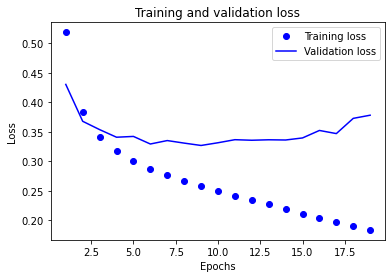

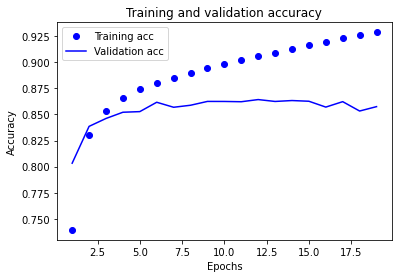

In [515]:
show_result(evaluate_result, history.history)

In [516]:
show_embedding_layer(model.layers[0], word_to_index, '영화')

생성된 임베딩 레이어 shape:  (10004, 200)
영화 와(과) 비슷한 항목들:  [('다큐멘터리', 0.7275925874710083), ('영화사', 0.7146768569946289), ('드라마', 0.7022181749343872), ('뮤지컬', 0.7007280588150024), ('코미디', 0.6962125897407532), ('영화인', 0.6659983396530151), ('스릴러', 0.6512220501899719), ('애니메이션', 0.6440232396125793), ('시트콤', 0.6372201442718506), ('로맨스', 0.6345106959342957)]


# Conv1D + pre embedding 모델

모델 생성

In [517]:
embeddings_initializer = load_embeddings_initializer(word_to_index)
model = make_model_2(x_train.shape[1], word_to_index, embeddings_initializer=embeddings_initializer)

5818 개 단어가 사전 임베딩에 추가 되었습니다
임베딩 초가화가 있는 모델입니다
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_69 (Embedding)     (None, 50, 200)           2000800   
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 44, 16)            22416     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 8, 16)             0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d_44 (Glo (None, 16)                0         
_________________________________________________________________
dense_150 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_1

훈련 및 테스트

In [518]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(x_train[:-num_val],
                    y_train[:-num_val],
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_train[-num_val:], y_train[-num_val:]),
                    verbose=1,
                    callbacks=[early_stopping])
evaluate_result = model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/100
227/227 [==============================] - 5s 21ms/step - loss: 0.5811 - accuracy: 0.6846 - val_loss: 0.4844 - val_accuracy: 0.7650
Epoch 2/100
227/227 [==============================] - 5s 21ms/step - loss: 0.4367 - accuracy: 0.7985 - val_loss: 0.4082 - val_accuracy: 0.8130
Epoch 3/100
227/227 [==============================] - 5s 21ms/step - loss: 0.3709 - accuracy: 0.8356 - val_loss: 0.3824 - val_accuracy: 0.8287
Epoch 4/100
227/227 [==============================] - 5s 21ms/step - loss: 0.3335 - accuracy: 0.8548 - val_loss: 0.3882 - val_accuracy: 0.8277
Epoch 5/100
227/227 [==============================] - 5s 21ms/step - loss: 0.3093 - accuracy: 0.8681 - val_loss: 0.3533 - val_accuracy: 0.8469
Epoch 6/100
227/227 [==============================] - 5s 21ms/step - loss: 0.2900 - accuracy: 0.8777 - val_loss: 0.3571 - val_accuracy: 0.8455
Epoch 7/100
227/227 [==============================] - 5s 21ms/step - loss: 0.2745 - accuracy: 0.8849 - val_loss: 0.3524 - val_accuracy:

결과 보여주기

테스트 결과:  [0.3515225648880005, 0.8495432734489441]


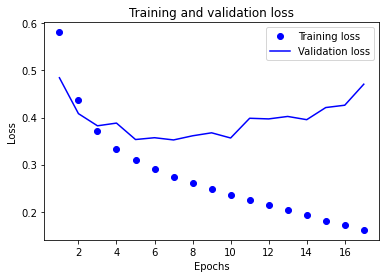

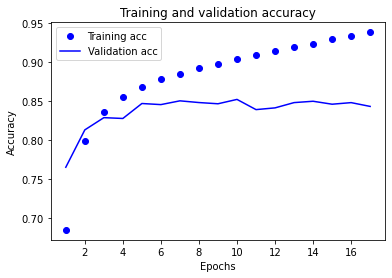

In [519]:
show_result(evaluate_result, history.history)

In [520]:
show_embedding_layer(model.layers[0], word_to_index, '영화')

생성된 임베딩 레이어 shape:  (10004, 200)
영화 와(과) 비슷한 항목들:  [('다큐멘터리', 0.7258369326591492), ('영화사', 0.7134283781051636), ('드라마', 0.7063372135162354), ('뮤지컬', 0.689577579498291), ('코미디', 0.6874529719352722), ('영화인', 0.670408308506012), ('스릴러', 0.6665253639221191), ('애니메이션', 0.6450049877166748), ('로맨스', 0.6384615898132324), ('서부극', 0.6367977261543274)]


## GlobalMaxPooling1D + pre embedding 모델

모델 생성

In [521]:
embeddings_initializer = load_embeddings_initializer(word_to_index)
model = make_model_3(x_train.shape[1], word_to_index, embeddings_initializer=embeddings_initializer)

5818 개 단어가 사전 임베딩에 추가 되었습니다
임베딩 초가화가 있는 모델입니다
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_70 (Embedding)     (None, 50, 200)           2000800   
_________________________________________________________________
global_max_pooling1d_45 (Glo (None, 200)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 8)                 1608      
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 9         
Total params: 2,002,417
Trainable params: 2,002,417
Non-trainable params: 0
_________________________________________________________________


훈련 및 테스트

In [522]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(x_train[:-num_val],
                    y_train[:-num_val],
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_train[-num_val:], y_train[-num_val:]),
                    verbose=1,
                    callbacks=[early_stopping])
evaluate_result = model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/100
227/227 [==============================] - 4s 19ms/step - loss: 0.6521 - accuracy: 0.6165 - val_loss: 0.6134 - val_accuracy: 0.6616
Epoch 2/100
227/227 [==============================] - 4s 19ms/step - loss: 0.5715 - accuracy: 0.7040 - val_loss: 0.5511 - val_accuracy: 0.7178
Epoch 3/100
227/227 [==============================] - 4s 19ms/step - loss: 0.5277 - accuracy: 0.7381 - val_loss: 0.5385 - val_accuracy: 0.7228
Epoch 4/100
227/227 [==============================] - 4s 19ms/step - loss: 0.4972 - accuracy: 0.7591 - val_loss: 0.4945 - val_accuracy: 0.7611
Epoch 5/100
227/227 [==============================] - 4s 19ms/step - loss: 0.4735 - accuracy: 0.7746 - val_loss: 0.4725 - val_accuracy: 0.7736
Epoch 6/100
227/227 [==============================] - 4s 19ms/step - loss: 0.4549 - accuracy: 0.7861 - val_loss: 0.4648 - val_accuracy: 0.7779
Epoch 7/100
227/227 [==============================] - 4s 19ms/step - loss: 0.4389 - accuracy: 0.7950 - val_loss: 0.4574 - val_accuracy:

결과 보여주기

테스트 결과:  [0.38268157839775085, 0.8319669365882874]


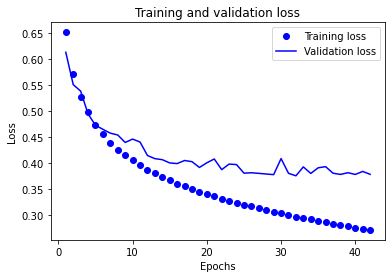

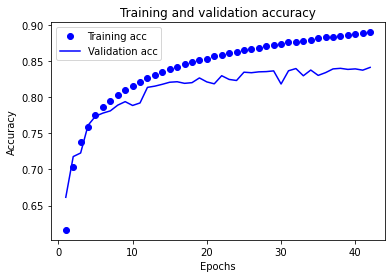

In [523]:
show_result(evaluate_result, history.history)

In [524]:
show_embedding_layer(model.layers[0], word_to_index, '영화')

생성된 임베딩 레이어 shape:  (10004, 200)
영화 와(과) 비슷한 항목들:  [('영화사', 0.724784255027771), ('다큐멘터리', 0.7052638530731201), ('코미디', 0.6919506788253784), ('드라마', 0.6827943325042725), ('뮤지컬', 0.6710318326950073), ('영화인', 0.6530396938323975), ('로맨스', 0.6436070203781128), ('스릴러', 0.6432133913040161), ('서부극', 0.6423659324645996), ('애니메이션', 0.6420172452926636)]


---

# 결론

임베딩 초기화로는 lms에 소개된 https://github.com/Kyubyong/wordvectors 를 사용하였다.   

전반적으로 82~85% 정도의 정확도를 보이는데, 여러 방법을 도입해봐도 큰 차이는 나타나지 않았다.   
주목해야 할 점은 word2vec을 임베딩 초기화 값으로 사용하여도 큰 영향을 보이지 않는다는 점이다.   
학습후 임베딩 레이어에서 '영화'와 비슷한 값들을 뽑아보면 word2vec을 사용한 모델에서는 거의 동일한 항목이 출력되고, 사용하지 않은 모델에서는 전혀 다른 항목이 출력된다.   
즉, 학습 과정에서 word2vec에 영향이 없다는 말고 같고, 이유는 아래와 같을 것으로 예상한다.

댓글에서 문장을 단어로 나누는 작업에서 mecab을 사용하였으나, 기존 word2vec에서는 kkma를 사용하였다.   
mecab과 kkma는 단어를 구분하는 기준이 약간 달라 같은 문장이라도 다른 단어들로 나뉘는 문제가 있다.   
실제로 word_to_index에서 word2vec의 값을 사용하는 단어 수를 세어보면 전체의 절반 이하가 된다.    
이를 보완하기 위해 kkma를 사용하려고 시도하였으나 kkma는 jvm을 사용하고 사용량이 많아지면 java heap size가 가득차는 문제가 발생하여 실패하였다.

word2vec를 제작한 소스를 보면 한국어 위키피디아를 사용하고 있는데, 위키피디아에서 사용되는 언어와 영화 댓글에 사용되는 언어는 서로 다르다고 볼 수 있다.   
'영화'와 비슷한 값을 관찰해보면, word2vec를 사용한 모델에서는 영화를 설명하기 위한 단어들이 많이 나오지만, word2vec을 사용하지 않은 모델에서는 문장 부호 등이 등장한다.   
또 댓글에서 사용되는 문장 부호나 자음만 있는 문자의 역할도 달라지는데, 주관적 느낌을 전달하기 위한 문장 부호나 이모티콘등이 있고, 그 중요도가 높기 때문이다.

더 높은 정확도를 보이기 위한 방안으로는   
1. 동일한 단어 구분 방법을 사용   
2. 댓글로 제작한 word2vec 제작     

등이 있을 것으로 예상된다.